In [5]:
import keras_tuner as kt
from tensorflow import keras
import numpy as np
import xarray as xr
import dask
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
from keras.layers import BatchNormalization
import tensorflow_probability as tfp
import clif
import clif.visualization as cviz
import matplotlib.pyplot as plt
import tensorflow.keras.backend as kb
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
import xarray

In [6]:
import haiku as hk
import jax 
from jax import numpy as jnp
from jax import value_and_grad

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

### Obtain Dataset

In [15]:
cd /Users/felixmeng/CME291/icme-xplore-bayes-spring22/src/data

/home/misbah/Desktop/CS 229/Project/icme-xplore-bayes-spring22/src/data


In [16]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

### Y_obs

In [18]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks=1)
Y_obs = dataset_obs['SWCF']
Y_scalar=Y_obs.values.var()
Y_shift=Y_obs.values.mean()
Y_np = (Y_obs.values-Y_shift)/np.sqrt(Y_scalar)
Y_np = np.array([Yi.flatten() for Yi in Y_np])

### X_E3SM

In [19]:
X_np = X.values
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


### Y_E3SM

In [20]:
X=X_s.copy()
X=(X-X.mean())/(X.std())
Y_obs=Y_np.copy()
Y=(Y.values-Y.values.mean())/(Y.values.std())
Y=np.array([Yi.flatten() for Yi in Y])

### PCA on the whole Y

In [243]:
# # Import PCA transform from sklearn
# from sklearn.decomposition import PCA
# pca = PCA(n_components=16,whiten=True)
# Yhat = pca.fit_transform(Y)

# # We can plot the explained variance which shows how much of the total variance the PCA components capture
# import matplotlib.pyplot as plt
# evr = pca.explained_variance_ratio_
# plt.plot(range(1,len(evr)+1),np.cumsum(evr))
# plt.grid(True)
# plt.title("Cumulative explained ratio")

### Cross Validation on Jax(Y-->Yhat)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=123)

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32),\

samples, features = X_train.shape

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((200, 5), (50, 5), (200, 1152), (50, 1152))

### PCA on the Train Y

Text(0.5, 1.0, 'Cumulative explained ratio')

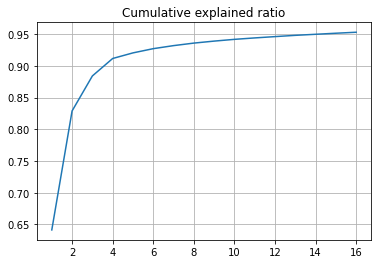

In [245]:
# Import PCA transform from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=16,whiten=True)
Yhat = pca.fit_transform(Y_train)

# We can plot the explained variance which shows how much of the total variance the PCA components capture
import matplotlib.pyplot as plt
evr = pca.explained_variance_ratio_
plt.plot(range(1,len(evr)+1),np.cumsum(evr))
plt.grid(True)
plt.title("Cumulative explained ratio")

In [246]:
Y_train=Yhat

In [247]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((200, 5), (50, 5), (200, 16), (50, 1152))

### Define Neural Network

In [248]:
##[5,80,60,60,16]
##[5,850,900,9000,1152]

In [249]:
def FeedForward(x):
    mlp=hk.nets.MLP(output_sizes=[5,80,60,60,16],activation=jax.nn.leaky_relu)
    return mlp(x)

In [250]:
model= hk.transform(FeedForward)

### init(rng, data):

This method takes seed for random numbers and a few samples as input. It then initialized the weights of the neural network and returns it. It returns an instance of FlatMap which is a dictionary-like object which has weights and biases of all layers of the neural network.

### apply(weights, rng, data)

This method takes weights, seed, and data features as input. It then performs forward pass-through data with weights and returns predictions.

In [251]:
rng=jax.random.PRNGKey(37)
params = model.init(rng, X_train[:5])
print("Weights Type : {}\n".format(type(params)))
for layer_name, weights in params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(params[layer_name]["w"].shape,params[layer_name]["b"].shape))

Weights Type : <class 'dict'>

mlp/~/linear_0
Weights : (5, 5), Biases : (5,)

mlp/~/linear_1
Weights : (5, 80), Biases : (80,)

mlp/~/linear_2
Weights : (80, 60), Biases : (60,)

mlp/~/linear_3
Weights : (60, 60), Biases : (60,)

mlp/~/linear_4
Weights : (60, 16), Biases : (16,)



In [252]:
preds=model.apply(params,rng,X_train)

### Loss Function

The function takes weights, input data, and actual target values as input. It then uses apply() method of the model to make predictions on input data using weights. 

In [253]:
def MeanSquaredErrorLoss(weights, input_data, actual):
    preds=model.apply(weights,rng,input_data) ## predictions
    preds=preds.squeeze() ## flattend
    mse=jnp.power(actual-preds,2).mean() ## MSE Difference
    return mse

### Update Weight

In [254]:
def UpdateWeights(weights, gradients):
    return weights - learning_rate* gradients ### Using SGD as optimizer

### Training the Neural Network

In [255]:
rng=jax.random.PRNGKey(42)
params=model.init(rng,X_train[:5])
epochs=10000
learning_rate=jnp.array(0.001)
batch_size=32
mse=[]

In [256]:
for i in range(1, epochs+1):
    batches = jnp.arange((X_train.shape[0]//batch_size)+1) ### Batch Indices

    losses = [] ## Record loss of each batch
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch, Y_batch = X_train[start:end], Y_train[start:end] ## Single batch of data

        loss, param_grads = value_and_grad(MeanSquaredErrorLoss)(params, X_batch, Y_batch)
        params = jax.tree_map(UpdateWeights, params, param_grads) ## Update Params
        losses.append(loss) ## Record Loss
    if i%100 == 0:
        print("MSE : {:.5f}".format(jnp.array(losses).mean()))


MSE : 0.94659
MSE : 0.93522
MSE : 0.92609
MSE : 0.91803
MSE : 0.91030
MSE : 0.90270
MSE : 0.89513
MSE : 0.88760
MSE : 0.88014
MSE : 0.87271
MSE : 0.86539
MSE : 0.85815
MSE : 0.85105
MSE : 0.84407
MSE : 0.83703
MSE : 0.83003
MSE : 0.82323
MSE : 0.81669
MSE : 0.81047
MSE : 0.80446
MSE : 0.79859
MSE : 0.79289
MSE : 0.78720
MSE : 0.78151
MSE : 0.77600
MSE : 0.77054
MSE : 0.76529
MSE : 0.76028
MSE : 0.75552
MSE : 0.75101
MSE : 0.74668
MSE : 0.74265
MSE : 0.73884
MSE : 0.73524
MSE : 0.73183
MSE : 0.72850
MSE : 0.72527
MSE : 0.72201
MSE : 0.71883
MSE : 0.71572
MSE : 0.71264
MSE : 0.70965
MSE : 0.70675
MSE : 0.70393
MSE : 0.70110
MSE : 0.69834
MSE : 0.69565
MSE : 0.69301
MSE : 0.69039
MSE : 0.68780
MSE : 0.68523
MSE : 0.68269
MSE : 0.68013
MSE : 0.67760
MSE : 0.67507
MSE : 0.67246
MSE : 0.66981
MSE : 0.66723
MSE : 0.66471
MSE : 0.66220
MSE : 0.65972
MSE : 0.65725
MSE : 0.65477
MSE : 0.65224
MSE : 0.64970
MSE : 0.64717
MSE : 0.64464
MSE : 0.64211
MSE : 0.63959
MSE : 0.63706
MSE : 0.63456
MSE : 

The jax.treemap() function takes function followed by arguments of function as input. The input arguments have a tree-like structure. It then performs a given function on each leaf of input arguments. 

### Make Predictions

In [259]:
PCA_train_preds = model.apply(params, rng, X_train)

In [260]:
PCA_test_preds = model.apply(params, rng, X_test)

### Apply Inverse PCA

In [261]:
train_preds=pca.inverse_transform(PCA_train_preds)
test_preds= pca.inverse_transform(PCA_test_preds)
##Y_test_1152=pca.inverse_transform(Y_test.copy())
Y_train_1152=pca.inverse_transform(Y_train.copy())

In [262]:
Mse_train=np.mean(np.square(Y_train_1152-train_preds))

In [288]:
Mse_test=np.mean(np.square(Y_test-test_preds))

In [289]:
print("Test  MSE Score : {:.4f}".format(Mse_test))
print("Train MSE Score : {:.4f}".format(Mse_train))

Test  MSE Score : 0.0049
Train MSE Score : 0.0031


In [290]:
from sklearn.metrics import r2_score

print("Test  R^2 Score : {:.2f}".format(r2_score(test_preds, Y_test)))
print("Train R^2 Score : {:.2f}".format(r2_score(train_preds, Y_train_1152)))

Test  R^2 Score : -2.56
Train R^2 Score : 0.75


### Plotting the Result

In [291]:
lat = dataset['lat'].values
lon = dataset['lon'].values

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

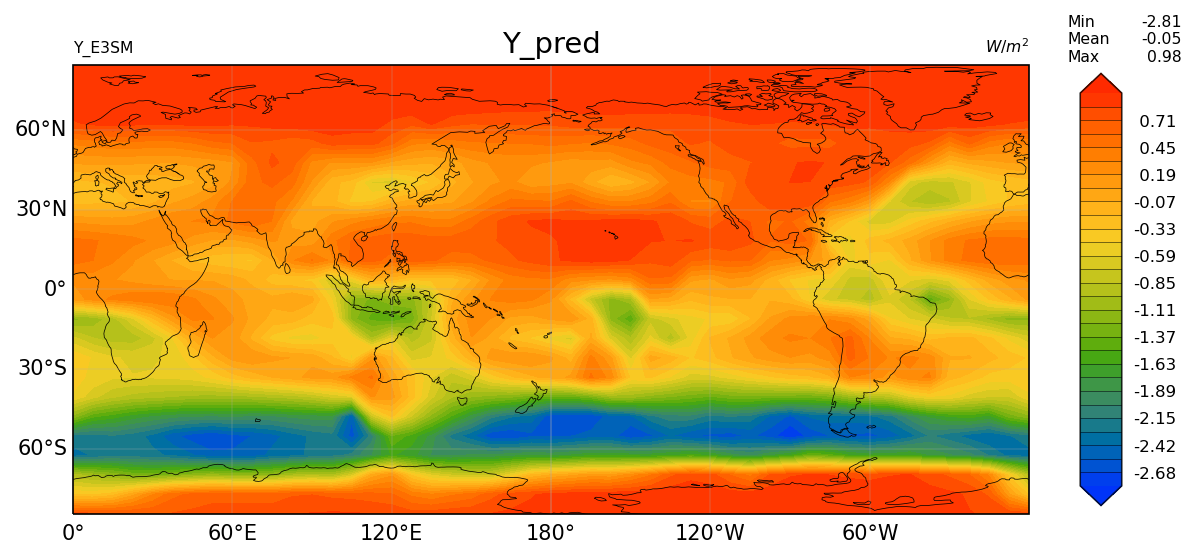

In [292]:
Y_plot=np.reshape(test_preds[0],(24,48))
y_pred_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_pred",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_pred_xr)

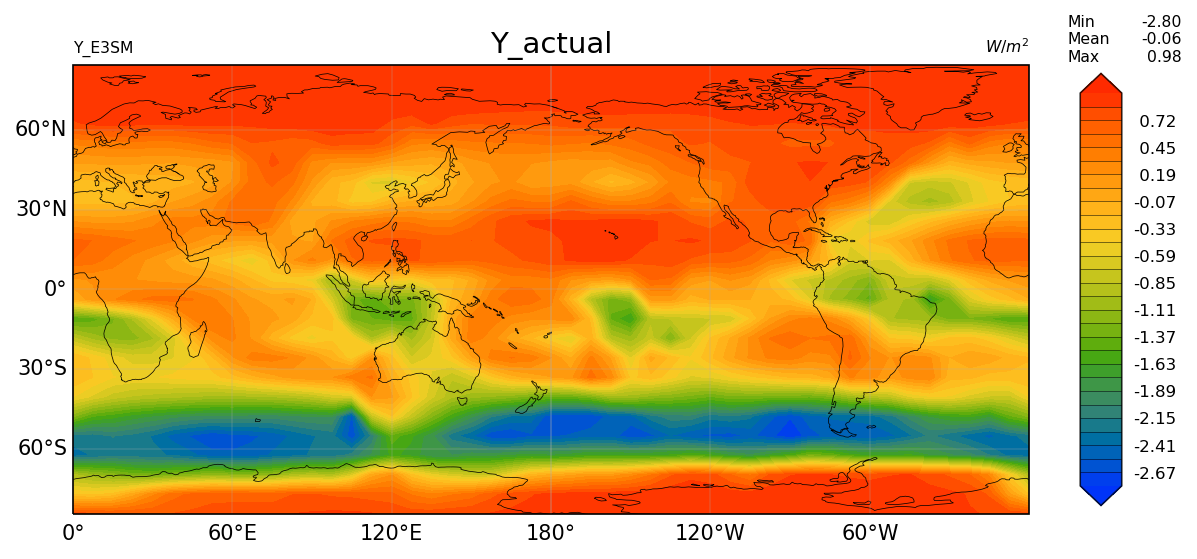

In [293]:
Y_plot=np.reshape(Y_test_1152[0],(24,48))
y_obs_xr = xarray.DataArray(Y_plot,coords={'lat': lat, 'lon':lon})
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default",
    title="Y_actual",
    rhs_title=r"$W/m^2$",
    lhs_title="Y_E3SM",
)
sample_plot.show(y_obs_xr)

/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/python3.9/site-packages/cartopy/crs.py:239: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/felixmeng/miniforge3/lib/

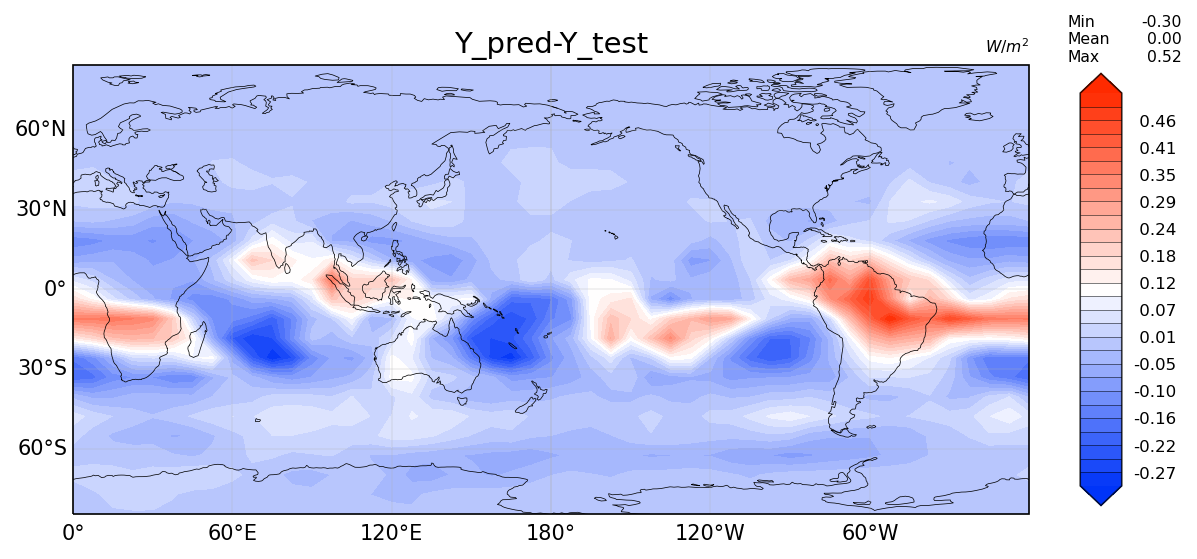

In [306]:
sample_plot = cviz.contour.plot_lat_lon(
    cmap_name="e3sm_default_diff",
    title="Y_pred-Y_test",
    rhs_title=r"$W/m^2$",
    lhs_title="",
)
sample_plot.show((y_pred_xr-y_obs_xr))

## Compare with Keras

In [ ]:
##[5,80,60,60,16]

In [270]:
import tensorflow as tf
import tensorflow.keras.backend as kb
from tensorflow import keras
def custom_loss(y_actual,y_pred):
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

In [281]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)

In [282]:
model = keras.Sequential(
    [
        tf.keras.layers.Dense(5, activation="LeakyReLU", name="layer1"),
        tf.keras.layers.Dense(80, activation="LeakyReLU", name="layer2"),
        tf.keras.layers.Dense(60,activation="LeakyReLU", name="layer3"),
        tf.keras.layers.Dense(60,activation="LeakyReLU", name="layer4"),
        tf.keras.layers.Dense(16, activation="LeakyReLU",name="layer5"),
    ]
)
model.compile(optimizer=tf.optimizers.Adam(),loss=custom_loss,
             metrics=[ tf.keras.metrics.RootMeanSquaredError()])

In [283]:
history=model.fit(X_train,Y_train,epochs=10000)

Epoch 1/10000
7/7 [==============================] - 1s 36ms/step - loss: 0.9966 - root_mean_squared_error: 0.9983
Epoch 2/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.9640 - root_mean_squared_error: 0.9818
Epoch 3/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.9384 - root_mean_squared_error: 0.9687
Epoch 4/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.9136 - root_mean_squared_error: 0.9558
Epoch 5/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.8888 - root_mean_squared_error: 0.9428
Epoch 6/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.8707 - root_mean_squared_error: 0.9331
Epoch 7/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.8532 - root_mean_squared_error: 0.9237
Epoch 8/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.8389 - root_mean_squared_error: 0.9159
Epoch 9/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.8228 - root_

Epoch 143/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4199 - root_mean_squared_error: 0.6480
Epoch 144/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4238 - root_mean_squared_error: 0.6510
Epoch 145/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4193 - root_mean_squared_error: 0.6475
Epoch 146/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4184 - root_mean_squared_error: 0.6468
Epoch 147/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4183 - root_mean_squared_error: 0.6467
Epoch 148/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4156 - root_mean_squared_error: 0.6447
Epoch 149/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4147 - root_mean_squared_error: 0.6440
Epoch 150/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.4167 - root_mean_squared_error: 0.6455
Epoch 151/10000
7/7 [==============================] - 0s 6ms/step - los

7/7 [==============================] - 0s 6ms/step - loss: 0.3221 - root_mean_squared_error: 0.5675
Epoch 284/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3186 - root_mean_squared_error: 0.5645
Epoch 285/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3202 - root_mean_squared_error: 0.5659
Epoch 286/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3176 - root_mean_squared_error: 0.5636
Epoch 287/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3181 - root_mean_squared_error: 0.5640
Epoch 288/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3201 - root_mean_squared_error: 0.5658
Epoch 289/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3165 - root_mean_squared_error: 0.5626
Epoch 290/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3161 - root_mean_squared_error: 0.5622
Epoch 291/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.3186 - root

7/7 [==============================] - 0s 7ms/step - loss: 0.2566 - root_mean_squared_error: 0.5066
Epoch 424/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2560 - root_mean_squared_error: 0.5059
Epoch 425/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2552 - root_mean_squared_error: 0.5052
Epoch 426/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2564 - root_mean_squared_error: 0.5064
Epoch 427/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2535 - root_mean_squared_error: 0.5035
Epoch 428/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2524 - root_mean_squared_error: 0.5024
Epoch 429/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2539 - root_mean_squared_error: 0.5039
Epoch 430/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.2554 - root_mean_squared_error: 0.5054
Epoch 431/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2524 - root

7/7 [==============================] - 0s 7ms/step - loss: 0.2130 - root_mean_squared_error: 0.4615
Epoch 564/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589
Epoch 565/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2071 - root_mean_squared_error: 0.4550
Epoch 566/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2092 - root_mean_squared_error: 0.4573
Epoch 567/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2078 - root_mean_squared_error: 0.4558
Epoch 568/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2110 - root_mean_squared_error: 0.4594
Epoch 569/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2138 - root_mean_squared_error: 0.4624
Epoch 570/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2126 - root_mean_squared_error: 0.4611
Epoch 571/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.2139 - root

7/7 [==============================] - 0s 6ms/step - loss: 0.1825 - root_mean_squared_error: 0.4272
Epoch 704/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1786 - root_mean_squared_error: 0.4226
Epoch 705/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1853 - root_mean_squared_error: 0.4304
Epoch 706/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1844 - root_mean_squared_error: 0.4294
Epoch 707/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1817 - root_mean_squared_error: 0.4263
Epoch 708/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1835 - root_mean_squared_error: 0.4284
Epoch 709/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1831 - root_mean_squared_error: 0.4279
Epoch 710/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1793 - root_mean_squared_error: 0.4235
Epoch 711/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1807 - root

7/7 [==============================] - 0s 6ms/step - loss: 0.1608 - root_mean_squared_error: 0.4010
Epoch 844/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1603 - root_mean_squared_error: 0.4003
Epoch 845/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1650 - root_mean_squared_error: 0.4062
Epoch 846/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1593 - root_mean_squared_error: 0.3991
Epoch 847/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1588 - root_mean_squared_error: 0.3985
Epoch 848/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1562 - root_mean_squared_error: 0.3952
Epoch 849/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1584 - root_mean_squared_error: 0.3980
Epoch 850/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1591 - root_mean_squared_error: 0.3989
Epoch 851/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1586 - root

7/7 [==============================] - 0s 6ms/step - loss: 0.1395 - root_mean_squared_error: 0.3734
Epoch 984/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1438 - root_mean_squared_error: 0.3792
Epoch 985/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1420 - root_mean_squared_error: 0.3769
Epoch 986/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1437 - root_mean_squared_error: 0.3791
Epoch 987/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1378 - root_mean_squared_error: 0.3712
Epoch 988/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1375 - root_mean_squared_error: 0.3709
Epoch 989/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1388 - root_mean_squared_error: 0.3725
Epoch 990/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1369 - root_mean_squared_error: 0.3700
Epoch 991/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1349 - root

7/7 [==============================] - 0s 6ms/step - loss: 0.1262 - root_mean_squared_error: 0.3552
Epoch 1124/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1243 - root_mean_squared_error: 0.3525
Epoch 1125/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1269 - root_mean_squared_error: 0.3563
Epoch 1126/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1268 - root_mean_squared_error: 0.3562
Epoch 1127/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1267 - root_mean_squared_error: 0.3560
Epoch 1128/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1228 - root_mean_squared_error: 0.3505
Epoch 1129/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1325 - root_mean_squared_error: 0.3640
Epoch 1130/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1326 - root_mean_squared_error: 0.3642
Epoch 1131/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.133

7/7 [==============================] - 0s 6ms/step - loss: 0.1132 - root_mean_squared_error: 0.3365
Epoch 1264/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1123 - root_mean_squared_error: 0.3351
Epoch 1265/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1113 - root_mean_squared_error: 0.3336
Epoch 1266/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1157 - root_mean_squared_error: 0.3401
Epoch 1267/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1177 - root_mean_squared_error: 0.3430
Epoch 1268/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1181 - root_mean_squared_error: 0.3437
Epoch 1269/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1154 - root_mean_squared_error: 0.3398
Epoch 1270/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1176 - root_mean_squared_error: 0.3430
Epoch 1271/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.115

7/7 [==============================] - 0s 6ms/step - loss: 0.1106 - root_mean_squared_error: 0.3326
Epoch 1404/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1132 - root_mean_squared_error: 0.3365
Epoch 1405/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1063 - root_mean_squared_error: 0.3260
Epoch 1406/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1044 - root_mean_squared_error: 0.3231
Epoch 1407/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1045 - root_mean_squared_error: 0.3232
Epoch 1408/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1060 - root_mean_squared_error: 0.3255
Epoch 1409/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1051 - root_mean_squared_error: 0.3242
Epoch 1410/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1032 - root_mean_squared_error: 0.3213
Epoch 1411/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.102

7/7 [==============================] - 0s 6ms/step - loss: 0.0962 - root_mean_squared_error: 0.3101
Epoch 1544/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0971 - root_mean_squared_error: 0.3116
Epoch 1545/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0948 - root_mean_squared_error: 0.3078
Epoch 1546/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1021 - root_mean_squared_error: 0.3196
Epoch 1547/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1014 - root_mean_squared_error: 0.3185
Epoch 1548/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0967 - root_mean_squared_error: 0.3110
Epoch 1549/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0969 - root_mean_squared_error: 0.3113
Epoch 1550/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0946 - root_mean_squared_error: 0.3076
Epoch 1551/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.098

7/7 [==============================] - 0s 6ms/step - loss: 0.0934 - root_mean_squared_error: 0.3055
Epoch 1684/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1014 - root_mean_squared_error: 0.3185
Epoch 1685/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0962 - root_mean_squared_error: 0.3102
Epoch 1686/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0964 - root_mean_squared_error: 0.3104
Epoch 1687/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1000 - root_mean_squared_error: 0.3162
Epoch 1688/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0963 - root_mean_squared_error: 0.3103
Epoch 1689/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.1026 - root_mean_squared_error: 0.3204
Epoch 1690/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0981 - root_mean_squared_error: 0.3132
Epoch 1691/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.100

7/7 [==============================] - 0s 6ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937
Epoch 1824/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910
Epoch 1825/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902
Epoch 1826/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0837 - root_mean_squared_error: 0.2893
Epoch 1827/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0848 - root_mean_squared_error: 0.2912
Epoch 1828/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0822 - root_mean_squared_error: 0.2867
Epoch 1829/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805
Epoch 1830/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0795 - root_mean_squared_error: 0.2820
Epoch 1831/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.080

7/7 [==============================] - 0s 6ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805
Epoch 1964/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0754 - root_mean_squared_error: 0.2746
Epoch 1965/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0772 - root_mean_squared_error: 0.2779
Epoch 1966/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0792 - root_mean_squared_error: 0.2814
Epoch 1967/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895
Epoch 1968/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0869 - root_mean_squared_error: 0.2948
Epoch 1969/10000
7/7 [==============================] - 0s 5ms/step - loss: 0.0834 - root_mean_squared_error: 0.2889
Epoch 1970/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0807 - root_mean_squared_error: 0.2841
Epoch 1971/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.083

7/7 [==============================] - 0s 6ms/step - loss: 0.0660 - root_mean_squared_error: 0.2569
Epoch 2104/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571
Epoch 2105/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0731 - root_mean_squared_error: 0.2703
Epoch 2106/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0763 - root_mean_squared_error: 0.2762
Epoch 2107/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0755 - root_mean_squared_error: 0.2747
Epoch 2108/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0765 - root_mean_squared_error: 0.2766
Epoch 2109/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782
Epoch 2110/10000
7/7 [==============================] - 0s 5ms/step - loss: 0.0762 - root_mean_squared_error: 0.2761
Epoch 2111/10000
7/7 [==============================] - 0s 5ms/step - loss: 0.085

7/7 [==============================] - 0s 8ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617
Epoch 2244/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0730 - root_mean_squared_error: 0.2702
Epoch 2245/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0774 - root_mean_squared_error: 0.2781
Epoch 2246/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0698 - root_mean_squared_error: 0.2641
Epoch 2247/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0696 - root_mean_squared_error: 0.2638
Epoch 2248/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0678 - root_mean_squared_error: 0.2604
Epoch 2249/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0769 - root_mean_squared_error: 0.2773
Epoch 2250/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895
Epoch 2251/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.084

7/7 [==============================] - 0s 6ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554
Epoch 2384/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0678 - root_mean_squared_error: 0.2603
Epoch 2385/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0695 - root_mean_squared_error: 0.2636
Epoch 2386/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0669 - root_mean_squared_error: 0.2587
Epoch 2387/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555
Epoch 2388/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0639 - root_mean_squared_error: 0.2527
Epoch 2389/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0605 - root_mean_squared_error: 0.2460
Epoch 2390/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0581 - root_mean_squared_error: 0.2410
Epoch 2391/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.057

7/7 [==============================] - 0s 7ms/step - loss: 0.0800 - root_mean_squared_error: 0.2828
Epoch 2524/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0709 - root_mean_squared_error: 0.2663
Epoch 2525/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0686 - root_mean_squared_error: 0.2619
Epoch 2526/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0721 - root_mean_squared_error: 0.2685
Epoch 2527/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0751 - root_mean_squared_error: 0.2740
Epoch 2528/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0683 - root_mean_squared_error: 0.2614
Epoch 2529/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0715 - root_mean_squared_error: 0.2674
Epoch 2530/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0740 - root_mean_squared_error: 0.2720
Epoch 2531/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.069

7/7 [==============================] - 0s 6ms/step - loss: 0.0774 - root_mean_squared_error: 0.2782
Epoch 2664/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0886 - root_mean_squared_error: 0.2977
Epoch 2665/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0818 - root_mean_squared_error: 0.2860
Epoch 2666/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0836 - root_mean_squared_error: 0.2891
Epoch 2667/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0867 - root_mean_squared_error: 0.2944
Epoch 2668/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0724 - root_mean_squared_error: 0.2691
Epoch 2669/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0710 - root_mean_squared_error: 0.2665
Epoch 2670/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0652 - root_mean_squared_error: 0.2554
Epoch 2671/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.063

7/7 [==============================] - 0s 6ms/step - loss: 0.0725 - root_mean_squared_error: 0.2692
Epoch 2804/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0632 - root_mean_squared_error: 0.2515
Epoch 2805/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0661 - root_mean_squared_error: 0.2571
Epoch 2806/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0630 - root_mean_squared_error: 0.2509
Epoch 2807/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0593 - root_mean_squared_error: 0.2436
Epoch 2808/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0562 - root_mean_squared_error: 0.2371
Epoch 2809/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0556 - root_mean_squared_error: 0.2357
Epoch 2810/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0550 - root_mean_squared_error: 0.2346
Epoch 2811/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.058

7/7 [==============================] - 0s 6ms/step - loss: 0.0704 - root_mean_squared_error: 0.2654
Epoch 2944/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0698 - root_mean_squared_error: 0.2642
Epoch 2945/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0725 - root_mean_squared_error: 0.2692
Epoch 2946/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0635 - root_mean_squared_error: 0.2520
Epoch 2947/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0704 - root_mean_squared_error: 0.2653
Epoch 2948/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0613 - root_mean_squared_error: 0.2477
Epoch 2949/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0565 - root_mean_squared_error: 0.2376
Epoch 2950/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368
Epoch 2951/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.063

7/7 [==============================] - 0s 6ms/step - loss: 0.0451 - root_mean_squared_error: 0.2123
Epoch 3084/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0478 - root_mean_squared_error: 0.2187
Epoch 3085/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0535 - root_mean_squared_error: 0.2313
Epoch 3086/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332
Epoch 3087/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0610 - root_mean_squared_error: 0.2470
Epoch 3088/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0591 - root_mean_squared_error: 0.2431
Epoch 3089/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578
Epoch 3090/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0732 - root_mean_squared_error: 0.2706
Epoch 3091/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.071

7/7 [==============================] - 0s 6ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086
Epoch 3224/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0422 - root_mean_squared_error: 0.2054
Epoch 3225/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0441 - root_mean_squared_error: 0.2100
Epoch 3226/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089
Epoch 3227/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - root_mean_squared_error: 0.2043
Epoch 3228/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0419 - root_mean_squared_error: 0.2046
Epoch 3229/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0454 - root_mean_squared_error: 0.2131
Epoch 3230/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0619 - root_mean_squared_error: 0.2489
Epoch 3231/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.053

7/7 [==============================] - 0s 6ms/step - loss: 0.0455 - root_mean_squared_error: 0.2132
Epoch 3364/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0446 - root_mean_squared_error: 0.2111
Epoch 3365/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0440 - root_mean_squared_error: 0.2097
Epoch 3366/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0449 - root_mean_squared_error: 0.2118
Epoch 3367/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0458 - root_mean_squared_error: 0.2141
Epoch 3368/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 3369/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0458 - root_mean_squared_error: 0.2139
Epoch 3370/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0446 - root_mean_squared_error: 0.2111
Epoch 3371/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.049

7/7 [==============================] - 0s 6ms/step - loss: 0.0452 - root_mean_squared_error: 0.2125
Epoch 3504/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0443 - root_mean_squared_error: 0.2104
Epoch 3505/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0445 - root_mean_squared_error: 0.2110
Epoch 3506/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107
Epoch 3507/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0433 - root_mean_squared_error: 0.2080
Epoch 3508/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103
Epoch 3509/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0436 - root_mean_squared_error: 0.2089
Epoch 3510/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035
Epoch 3511/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.038

7/7 [==============================] - 0s 6ms/step - loss: 0.0607 - root_mean_squared_error: 0.2464
Epoch 3644/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0553 - root_mean_squared_error: 0.2351
Epoch 3645/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0616 - root_mean_squared_error: 0.2483
Epoch 3646/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0562 - root_mean_squared_error: 0.2370
Epoch 3647/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0577 - root_mean_squared_error: 0.2403
Epoch 3648/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0551 - root_mean_squared_error: 0.2348
Epoch 3649/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278
Epoch 3650/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0549 - root_mean_squared_error: 0.2344
Epoch 3651/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.054

7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1874
Epoch 3784/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0380 - root_mean_squared_error: 0.1948
Epoch 3785/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0393 - root_mean_squared_error: 0.1981
Epoch 3786/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0438 - root_mean_squared_error: 0.2092
Epoch 3787/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0462 - root_mean_squared_error: 0.2148
Epoch 3788/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0421 - root_mean_squared_error: 0.2052
Epoch 3789/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086
Epoch 3790/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0416 - root_mean_squared_error: 0.2040
Epoch 3791/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.042

7/7 [==============================] - 0s 6ms/step - loss: 0.0479 - root_mean_squared_error: 0.2188
Epoch 3924/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0414 - root_mean_squared_error: 0.2034
Epoch 3925/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0385 - root_mean_squared_error: 0.1961
Epoch 3926/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948
Epoch 3927/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926
Epoch 3928/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - root_mean_squared_error: 0.1930
Epoch 3929/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - root_mean_squared_error: 0.1877
Epoch 3930/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0345 - root_mean_squared_error: 0.1856
Epoch 3931/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.034

7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926
Epoch 4064/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928
Epoch 4065/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0363 - root_mean_squared_error: 0.1906
Epoch 4066/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1872
Epoch 4067/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0355 - root_mean_squared_error: 0.1885
Epoch 4068/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0363 - root_mean_squared_error: 0.1904
Epoch 4069/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0349 - root_mean_squared_error: 0.1868
Epoch 4070/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902
Epoch 4071/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.035

7/7 [==============================] - 0s 6ms/step - loss: 0.0593 - root_mean_squared_error: 0.2434
Epoch 4204/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0560 - root_mean_squared_error: 0.2367
Epoch 4205/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0466 - root_mean_squared_error: 0.2158
Epoch 4206/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0493 - root_mean_squared_error: 0.2220
Epoch 4207/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0507 - root_mean_squared_error: 0.2251
Epoch 4208/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0509 - root_mean_squared_error: 0.2255
Epoch 4209/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0472 - root_mean_squared_error: 0.2174
Epoch 4210/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0435 - root_mean_squared_error: 0.2086
Epoch 4211/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.040

7/7 [==============================] - 0s 7ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159
Epoch 4344/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0527 - root_mean_squared_error: 0.2295
Epoch 4345/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0532 - root_mean_squared_error: 0.2306
Epoch 4346/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0443 - root_mean_squared_error: 0.2104
Epoch 4347/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0425 - root_mean_squared_error: 0.2060
Epoch 4348/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979
Epoch 4349/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0388 - root_mean_squared_error: 0.1970
Epoch 4350/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0352 - root_mean_squared_error: 0.1876
Epoch 4351/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.035

7/7 [==============================] - 0s 6ms/step - loss: 0.1087 - root_mean_squared_error: 0.3297
Epoch 4484/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0977 - root_mean_squared_error: 0.3126
Epoch 4485/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0767 - root_mean_squared_error: 0.2769
Epoch 4486/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0653 - root_mean_squared_error: 0.2555
Epoch 4487/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273
Epoch 4488/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198
Epoch 4489/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332
Epoch 4490/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0472 - root_mean_squared_error: 0.2173
Epoch 4491/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.050

7/7 [==============================] - 0s 6ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945
Epoch 4624/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0386 - root_mean_squared_error: 0.1966
Epoch 4625/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0358 - root_mean_squared_error: 0.1891
Epoch 4626/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0390 - root_mean_squared_error: 0.1976
Epoch 4627/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0370 - root_mean_squared_error: 0.1923
Epoch 4628/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0444 - root_mean_squared_error: 0.2107
Epoch 4629/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130
Epoch 4630/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0466 - root_mean_squared_error: 0.2159
Epoch 4631/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.045

7/7 [==============================] - 0s 6ms/step - loss: 0.0445 - root_mean_squared_error: 0.2111
Epoch 4764/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0417 - root_mean_squared_error: 0.2042
Epoch 4765/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0460 - root_mean_squared_error: 0.2146
Epoch 4766/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030
Epoch 4767/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0385 - root_mean_squared_error: 0.1962
Epoch 4768/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0370 - root_mean_squared_error: 0.1923
Epoch 4769/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836
Epoch 4770/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798
Epoch 4771/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.030

7/7 [==============================] - 0s 7ms/step - loss: 0.0345 - root_mean_squared_error: 0.1858
Epoch 4904/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0318 - root_mean_squared_error: 0.1783
Epoch 4905/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0303 - root_mean_squared_error: 0.1741
Epoch 4906/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0315 - root_mean_squared_error: 0.1775
Epoch 4907/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0321 - root_mean_squared_error: 0.1792
Epoch 4908/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786
Epoch 4909/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791
Epoch 4910/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0300 - root_mean_squared_error: 0.1731
Epoch 4911/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.028

7/7 [==============================] - 0s 6ms/step - loss: 0.0416 - root_mean_squared_error: 0.2039
Epoch 5044/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0389 - root_mean_squared_error: 0.1972
Epoch 5045/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0366 - root_mean_squared_error: 0.1913
Epoch 5046/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0358 - root_mean_squared_error: 0.1893
Epoch 5047/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0384 - root_mean_squared_error: 0.1960
Epoch 5048/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0411 - root_mean_squared_error: 0.2027
Epoch 5049/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0400 - root_mean_squared_error: 0.1999
Epoch 5050/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979
Epoch 5051/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.037

7/7 [==============================] - 0s 6ms/step - loss: 0.0448 - root_mean_squared_error: 0.2116
Epoch 5184/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0460 - root_mean_squared_error: 0.2145
Epoch 5185/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0400 - root_mean_squared_error: 0.1999
Epoch 5186/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0391 - root_mean_squared_error: 0.1977
Epoch 5187/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0366 - root_mean_squared_error: 0.1912
Epoch 5188/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880
Epoch 5189/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0437 - root_mean_squared_error: 0.2090
Epoch 5190/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0544 - root_mean_squared_error: 0.2332
Epoch 5191/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.052

7/7 [==============================] - 0s 6ms/step - loss: 0.0380 - root_mean_squared_error: 0.1949
Epoch 5324/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0367 - root_mean_squared_error: 0.1914
Epoch 5325/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0339 - root_mean_squared_error: 0.1840
Epoch 5326/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0341 - root_mean_squared_error: 0.1847
Epoch 5327/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0363 - root_mean_squared_error: 0.1905
Epoch 5328/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832
Epoch 5329/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0348 - root_mean_squared_error: 0.1866
Epoch 5330/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0367 - root_mean_squared_error: 0.1915
Epoch 5331/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.038

7/7 [==============================] - 0s 6ms/step - loss: 0.0336 - root_mean_squared_error: 0.1832
Epoch 5464/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0311 - root_mean_squared_error: 0.1763
Epoch 5465/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0328 - root_mean_squared_error: 0.1812
Epoch 5466/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0319 - root_mean_squared_error: 0.1785
Epoch 5467/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755
Epoch 5468/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0316 - root_mean_squared_error: 0.1779
Epoch 5469/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0334 - root_mean_squared_error: 0.1829
Epoch 5470/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - root_mean_squared_error: 0.1719
Epoch 5471/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.030

7/7 [==============================] - 0s 6ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088
Epoch 5604/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0445 - root_mean_squared_error: 0.2109
Epoch 5605/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0473 - root_mean_squared_error: 0.2174
Epoch 5606/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0472 - root_mean_squared_error: 0.2172
Epoch 5607/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0520 - root_mean_squared_error: 0.2280
Epoch 5608/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0429 - root_mean_squared_error: 0.2072
Epoch 5609/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0408 - root_mean_squared_error: 0.2019
Epoch 5610/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0389 - root_mean_squared_error: 0.1974
Epoch 5611/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.037

7/7 [==============================] - 0s 6ms/step - loss: 0.0351 - root_mean_squared_error: 0.1875
Epoch 5744/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0353 - root_mean_squared_error: 0.1880
Epoch 5745/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910
Epoch 5746/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0373 - root_mean_squared_error: 0.1931
Epoch 5747/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0377 - root_mean_squared_error: 0.1941
Epoch 5748/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0561 - root_mean_squared_error: 0.2368
Epoch 5749/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0702 - root_mean_squared_error: 0.2649
Epoch 5750/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823
Epoch 5751/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.068

7/7 [==============================] - 0s 6ms/step - loss: 0.0407 - root_mean_squared_error: 0.2018
Epoch 5884/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0373 - root_mean_squared_error: 0.1932
Epoch 5885/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0337 - root_mean_squared_error: 0.1835
Epoch 5886/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0352 - root_mean_squared_error: 0.1875
Epoch 5887/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0305 - root_mean_squared_error: 0.1747
Epoch 5888/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0424 - root_mean_squared_error: 0.2059
Epoch 5889/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0476 - root_mean_squared_error: 0.2182
Epoch 5890/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0406 - root_mean_squared_error: 0.2014
Epoch 5891/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.038

7/7 [==============================] - 0s 6ms/step - loss: 0.0238 - root_mean_squared_error: 0.1544
Epoch 6024/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0245 - root_mean_squared_error: 0.1565
Epoch 6025/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0247 - root_mean_squared_error: 0.1572
Epoch 6026/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0263 - root_mean_squared_error: 0.1623
Epoch 6027/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0297 - root_mean_squared_error: 0.1724
Epoch 6028/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0292 - root_mean_squared_error: 0.1710
Epoch 6029/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0294 - root_mean_squared_error: 0.1716
Epoch 6030/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662
Epoch 6031/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.029

7/7 [==============================] - 0s 6ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902
Epoch 6164/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0359 - root_mean_squared_error: 0.1895
Epoch 6165/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0342 - root_mean_squared_error: 0.1851
Epoch 6166/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945
Epoch 6167/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0365 - root_mean_squared_error: 0.1910
Epoch 6168/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0369 - root_mean_squared_error: 0.1920
Epoch 6169/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791
Epoch 6170/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844
Epoch 6171/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.036

7/7 [==============================] - 0s 7ms/step - loss: 0.0244 - root_mean_squared_error: 0.1562
Epoch 6304/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0260 - root_mean_squared_error: 0.1614
Epoch 6305/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0312 - root_mean_squared_error: 0.1767
Epoch 6306/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664
Epoch 6307/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632
Epoch 6308/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0345 - root_mean_squared_error: 0.1857
Epoch 6309/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0377 - root_mean_squared_error: 0.1942
Epoch 6310/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0324 - root_mean_squared_error: 0.1801
Epoch 6311/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.029

7/7 [==============================] - 0s 6ms/step - loss: 0.0229 - root_mean_squared_error: 0.1512
Epoch 6444/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0225 - root_mean_squared_error: 0.1501
Epoch 6445/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0228 - root_mean_squared_error: 0.1511
Epoch 6446/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0218 - root_mean_squared_error: 0.1477
Epoch 6447/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472
Epoch 6448/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0218 - root_mean_squared_error: 0.1476
Epoch 6449/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0215 - root_mean_squared_error: 0.1467
Epoch 6450/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0208 - root_mean_squared_error: 0.1444
Epoch 6451/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.020

7/7 [==============================] - 0s 6ms/step - loss: 0.0332 - root_mean_squared_error: 0.1821
Epoch 6584/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0355 - root_mean_squared_error: 0.1884
Epoch 6585/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867
Epoch 6586/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798
Epoch 6587/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0307 - root_mean_squared_error: 0.1754
Epoch 6588/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717
Epoch 6589/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0304 - root_mean_squared_error: 0.1744
Epoch 6590/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963
Epoch 6591/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.039

7/7 [==============================] - 0s 6ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798
Epoch 6724/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0291 - root_mean_squared_error: 0.1705
Epoch 6725/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0273 - root_mean_squared_error: 0.1652
Epoch 6726/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1573
Epoch 6727/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1548
Epoch 6728/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0231 - root_mean_squared_error: 0.1521
Epoch 6729/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0232 - root_mean_squared_error: 0.1522
Epoch 6730/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0229 - root_mean_squared_error: 0.1513
Epoch 6731/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.024

7/7 [==============================] - 0s 6ms/step - loss: 0.0214 - root_mean_squared_error: 0.1464
Epoch 6864/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0221 - root_mean_squared_error: 0.1486
Epoch 6865/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517
Epoch 6866/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550
Epoch 6867/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1550
Epoch 6868/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1575
Epoch 6869/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0254 - root_mean_squared_error: 0.1592
Epoch 6870/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0258 - root_mean_squared_error: 0.1605
Epoch 6871/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.024

7/7 [==============================] - 0s 6ms/step - loss: 0.0271 - root_mean_squared_error: 0.1646
Epoch 7004/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0261 - root_mean_squared_error: 0.1615
Epoch 7005/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0214 - root_mean_squared_error: 0.1463
Epoch 7006/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508
Epoch 7007/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 7008/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523
Epoch 7009/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0240 - root_mean_squared_error: 0.1551
Epoch 7010/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529
Epoch 7011/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.026

7/7 [==============================] - 0s 6ms/step - loss: 0.0381 - root_mean_squared_error: 0.1951
Epoch 7144/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939
Epoch 7145/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0347 - root_mean_squared_error: 0.1863
Epoch 7146/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0395 - root_mean_squared_error: 0.1987
Epoch 7147/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0506 - root_mean_squared_error: 0.2249
Epoch 7148/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0589 - root_mean_squared_error: 0.2427
Epoch 7149/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0546 - root_mean_squared_error: 0.2336
Epoch 7150/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0503 - root_mean_squared_error: 0.2242
Epoch 7151/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.054

7/7 [==============================] - 0s 6ms/step - loss: 0.0302 - root_mean_squared_error: 0.1737
Epoch 7284/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0309 - root_mean_squared_error: 0.1757
Epoch 7285/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0296 - root_mean_squared_error: 0.1722
Epoch 7286/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0281 - root_mean_squared_error: 0.1675
Epoch 7287/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0293 - root_mean_squared_error: 0.1713
Epoch 7288/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0317 - root_mean_squared_error: 0.1780
Epoch 7289/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0301 - root_mean_squared_error: 0.1734
Epoch 7290/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0270 - root_mean_squared_error: 0.1643
Epoch 7291/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.027

7/7 [==============================] - 0s 7ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529
Epoch 7424/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574
Epoch 7425/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0246 - root_mean_squared_error: 0.1568
Epoch 7426/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574
Epoch 7427/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0243 - root_mean_squared_error: 0.1558
Epoch 7428/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496
Epoch 7429/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0234 - root_mean_squared_error: 0.1530
Epoch 7430/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0239 - root_mean_squared_error: 0.1546
Epoch 7431/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.022

7/7 [==============================] - 0s 6ms/step - loss: 0.0247 - root_mean_squared_error: 0.1571
Epoch 7564/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551
Epoch 7565/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0244 - root_mean_squared_error: 0.1561
Epoch 7566/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580
Epoch 7567/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574
Epoch 7568/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629
Epoch 7569/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627
Epoch 7570/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0321 - root_mean_squared_error: 0.1791
Epoch 7571/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.034

7/7 [==============================] - 0s 6ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541
Epoch 7704/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0290 - root_mean_squared_error: 0.1702
Epoch 7705/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0283 - root_mean_squared_error: 0.1681
Epoch 7706/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0289 - root_mean_squared_error: 0.1699
Epoch 7707/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721
Epoch 7708/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0363 - root_mean_squared_error: 0.1904
Epoch 7709/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0339 - root_mean_squared_error: 0.1840
Epoch 7710/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0364 - root_mean_squared_error: 0.1908
Epoch 7711/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.040

7/7 [==============================] - 0s 6ms/step - loss: 0.0233 - root_mean_squared_error: 0.1525
Epoch 7844/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0281 - root_mean_squared_error: 0.1677
Epoch 7845/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0308 - root_mean_squared_error: 0.1755
Epoch 7846/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0296 - root_mean_squared_error: 0.1721
Epoch 7847/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0287 - root_mean_squared_error: 0.1693
Epoch 7848/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0324 - root_mean_squared_error: 0.1799
Epoch 7849/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0323 - root_mean_squared_error: 0.1798
Epoch 7850/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0307 - root_mean_squared_error: 0.1751
Epoch 7851/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.030

7/7 [==============================] - 0s 6ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254
Epoch 7984/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246
Epoch 7985/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233
Epoch 7986/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265
Epoch 7987/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304
Epoch 7988/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327
Epoch 7989/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0168 - root_mean_squared_error: 0.1298
Epoch 7990/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314
Epoch 7991/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.017

7/7 [==============================] - 0s 7ms/step - loss: 0.0193 - root_mean_squared_error: 0.1389
Epoch 8124/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323
Epoch 8125/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354
Epoch 8126/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0185 - root_mean_squared_error: 0.1361
Epoch 8127/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0192 - root_mean_squared_error: 0.1384
Epoch 8128/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0199 - root_mean_squared_error: 0.1412
Epoch 8129/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0205 - root_mean_squared_error: 0.1432
Epoch 8130/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0218 - root_mean_squared_error: 0.1476
Epoch 8131/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.025

7/7 [==============================] - 0s 6ms/step - loss: 0.0259 - root_mean_squared_error: 0.1608
Epoch 8264/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0239 - root_mean_squared_error: 0.1545
Epoch 8265/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0232 - root_mean_squared_error: 0.1523
Epoch 8266/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0236 - root_mean_squared_error: 0.1536
Epoch 8267/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0233 - root_mean_squared_error: 0.1528
Epoch 8268/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0233 - root_mean_squared_error: 0.1528
Epoch 8269/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508
Epoch 8270/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520
Epoch 8271/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.025

7/7 [==============================] - 0s 6ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420
Epoch 8404/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0234 - root_mean_squared_error: 0.1529
Epoch 8405/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0245 - root_mean_squared_error: 0.1565
Epoch 8406/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0283 - root_mean_squared_error: 0.1681
Epoch 8407/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0328 - root_mean_squared_error: 0.1810
Epoch 8408/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0298 - root_mean_squared_error: 0.1725
Epoch 8409/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0261 - root_mean_squared_error: 0.1616
Epoch 8410/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0257 - root_mean_squared_error: 0.1603
Epoch 8411/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.026

7/7 [==============================] - 0s 6ms/step - loss: 0.0244 - root_mean_squared_error: 0.1563
Epoch 8544/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0262 - root_mean_squared_error: 0.1619
Epoch 8545/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0283 - root_mean_squared_error: 0.1684
Epoch 8546/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0265 - root_mean_squared_error: 0.1629
Epoch 8547/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0278 - root_mean_squared_error: 0.1668
Epoch 8548/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0266 - root_mean_squared_error: 0.1632
Epoch 8549/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664
Epoch 8550/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0259 - root_mean_squared_error: 0.1609
Epoch 8551/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.024

7/7 [==============================] - 0s 6ms/step - loss: 0.0399 - root_mean_squared_error: 0.1997
Epoch 8684/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0400 - root_mean_squared_error: 0.2000
Epoch 8685/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0320 - root_mean_squared_error: 0.1788
Epoch 8686/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0284 - root_mean_squared_error: 0.1687
Epoch 8687/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0301 - root_mean_squared_error: 0.1736
Epoch 8688/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0302 - root_mean_squared_error: 0.1739
Epoch 8689/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0260 - root_mean_squared_error: 0.1612
Epoch 8690/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0280 - root_mean_squared_error: 0.1674
Epoch 8691/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.031

7/7 [==============================] - 0s 6ms/step - loss: 0.0170 - root_mean_squared_error: 0.1304
Epoch 8824/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0183 - root_mean_squared_error: 0.1352
Epoch 8825/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0184 - root_mean_squared_error: 0.1357
Epoch 8826/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0199 - root_mean_squared_error: 0.1410
Epoch 8827/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370
Epoch 8828/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1430
Epoch 8829/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0214 - root_mean_squared_error: 0.1462
Epoch 8830/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0257 - root_mean_squared_error: 0.1602
Epoch 8831/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.028

7/7 [==============================] - 0s 6ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373
Epoch 8964/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381
Epoch 8965/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1401
Epoch 8966/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388
Epoch 8967/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0221 - root_mean_squared_error: 0.1485
Epoch 8968/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514
Epoch 8969/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0219 - root_mean_squared_error: 0.1478
Epoch 8970/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452
Epoch 8971/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.022

7/7 [==============================] - 0s 6ms/step - loss: 0.0196 - root_mean_squared_error: 0.1400
Epoch 9104/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0182 - root_mean_squared_error: 0.1350
Epoch 9105/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254
Epoch 9106/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288
Epoch 9107/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230
Epoch 9108/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244
Epoch 9109/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0149 - root_mean_squared_error: 0.1222
Epoch 9110/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1164
Epoch 9111/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.013

7/7 [==============================] - 0s 6ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662
Epoch 9244/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0275 - root_mean_squared_error: 0.1659
Epoch 9245/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0285 - root_mean_squared_error: 0.1690
Epoch 9246/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0306 - root_mean_squared_error: 0.1751
Epoch 9247/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814
Epoch 9248/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696
Epoch 9249/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0319 - root_mean_squared_error: 0.1786
Epoch 9250/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0327 - root_mean_squared_error: 0.1809
Epoch 9251/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.034

7/7 [==============================] - 0s 6ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309
Epoch 9384/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312
Epoch 9385/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226
Epoch 9386/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282
Epoch 9387/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345
Epoch 9388/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420
Epoch 9389/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574
Epoch 9390/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0285 - root_mean_squared_error: 0.1687
Epoch 9391/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.028

7/7 [==============================] - 0s 6ms/step - loss: 0.0179 - root_mean_squared_error: 0.1338
Epoch 9524/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316
Epoch 9525/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294
Epoch 9526/10000
7/7 [==============================] - 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346
Epoch 9527/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0205 - root_mean_squared_error: 0.1431
Epoch 9528/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0215 - root_mean_squared_error: 0.1466
Epoch 9529/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0211 - root_mean_squared_error: 0.1454
Epoch 9530/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0264 - root_mean_squared_error: 0.1626
Epoch 9531/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.029

7/7 [==============================] - 0s 6ms/step - loss: 0.0297 - root_mean_squared_error: 0.1723
Epoch 9664/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0293 - root_mean_squared_error: 0.1712
Epoch 9665/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0288 - root_mean_squared_error: 0.1698
Epoch 9666/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0403 - root_mean_squared_error: 0.2008
Epoch 9667/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0374 - root_mean_squared_error: 0.1935
Epoch 9668/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0382 - root_mean_squared_error: 0.1955
Epoch 9669/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0360 - root_mean_squared_error: 0.1898
Epoch 9670/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0340 - root_mean_squared_error: 0.1845
Epoch 9671/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.031

7/7 [==============================] - 0s 6ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233
Epoch 9804/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207
Epoch 9805/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278
Epoch 9806/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0162 - root_mean_squared_error: 0.1271
Epoch 9807/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261
Epoch 9808/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278
Epoch 9809/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0194 - root_mean_squared_error: 0.1392
Epoch 9810/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0208 - root_mean_squared_error: 0.1444
Epoch 9811/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.021

7/7 [==============================] - 0s 7ms/step - loss: 0.0218 - root_mean_squared_error: 0.1477
Epoch 9944/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0208 - root_mean_squared_error: 0.1442
Epoch 9945/10000
7/7 [==============================] - 0s 7ms/step - loss: 0.0223 - root_mean_squared_error: 0.1493
Epoch 9946/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0243 - root_mean_squared_error: 0.1560
Epoch 9947/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514
Epoch 9948/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0275 - root_mean_squared_error: 0.1660
Epoch 9949/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0285 - root_mean_squared_error: 0.1689
Epoch 9950/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.0288 - root_mean_squared_error: 0.1696
Epoch 9951/10000
7/7 [==============================] - 0s 6ms/step - loss: 0.031

In [303]:
test_pred_keras=model.predict(np.array(X_test))
test_preds_1152= pca.inverse_transform(PCA_test_preds)

In [304]:
Mse_test=np.mean(np.square(Y_test_1152-test_preds))

In [305]:
Mse_test

0.0037288861

In [26]:
Y_train.shape

(200, 1152)

## Compare Dummy 

In [22]:
from scipy import stats

0.02435368187725544
k = 5, MSE = 0.00525186313316226
0.005940885344895962


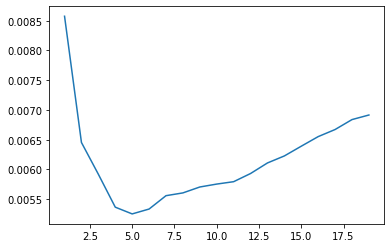

In [43]:
# calculate the cross validation score as well
from sklearn.model_selection import cross_val_score
# Now we can create a dummy predictor mapping X -> Y
from sklearn.dummy import DummyRegressor
dummyreg = DummyRegressor(strategy='mean')
from sklearn.metrics import mean_squared_error

cv_scores = cross_val_score(dummyreg,X,Y,scoring='neg_mean_squared_error')
print(-1*cv_scores.mean())

# try k nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
# try k nearest neighbors
from sklearn.neighbors import KNeighborsRegressor
errs = []
for i in range(1,20):
    Knn= KNeighborsRegressor(n_neighbors=i)
    #Knn.fit(X_train,Y_train)
    #print(np.mean((Knn.predict(X_test) - Y_test)**2))
    err = -1*cross_val_score(Knn,X,Y,scoring='neg_mean_squared_error').mean()
    errs.append([i,err])
errs = np.array(errs).T
plt.plot(errs[0], errs[1])
print('k = {}, MSE = {}'.format(int(errs[:,np.argmin(errs[1])][0]), errs[:,np.argmin(errs[1])][1]))
# linear regression
from sklearn.linear_model import LinearRegression
Linear= LinearRegression()
#Linear.fit(X,Y) 
print(-1*cross_val_score(Linear,X,Y,scoring='neg_mean_squared_error').mean())

array([5.        , 0.00525186])